# Tutorial: using Docta to curate your tabular data in seconds

In [1]:
import sys
import os
os.chdir('..')
o_path = os.getcwd()
# print(o_path)
sys.path.append(o_path) # set path so that modules from other foloders can be loaded

### Section 1: Diagnose label errors in the dataset

In [7]:
%run ./tools/diagnose_tabular.py

Tabular_train
Tabular-data load finished
Detecting label errors with simifeat.
Estimating consensus patterns...


100%|██████████| 50/50 [00:14<00:00,  3.34it/s]


Estimating consensus patterns... [Done]
Use cpu to solve equations


100%|██████████| 1501/1501 [00:02<00:00, 705.52it/s]


Solve equations... [Done]
Use SimiFeat-rank to detect label errors.


100%|██████████| 51/51 [00:02<00:00, 21.57it/s]


[SimiFeat] We find 2250 corrupted instances from 7400 instances
Report saved to ./results/Tabular_train/label_error_Tabular_train_diagnose_report.pt


### Take a look at the Docta cured/corrected labels

In [8]:
print(f"Load docta cured labels from {report_path}")
cured_labels = torch.load(report_path)

Load docta cured labels from ./results/Tabular_train/label_error_Tabular_train_diagnose_report.pt


### Check the detected samples with label error

In [9]:
detected = cured_labels.detection['label_error']

In [10]:
detected[0]

[731, 0.9811320754716981]

In [11]:
detected_idx = [detected[i][0] for i in range(len(detected))]

In [12]:
# This function takes the docta report, error_report, and train data as input, outputs a filter X_train, y_train
def filter_arrays(X_noisy, y_noisy, error_report, thres=0.8):
    # Gather indices where second element in error report > thres
    store_idx = [a for a, b in error_report if b > thres]
    all_idx = range(len(y_noisy))
    filtered_idx = [elem for elem in all_idx if elem not in store_idx]
    # Filter X_noisy and y_noisy with indices in store_idx
    X_noisy_filtered = X_noisy[filtered_idx]
    y_noisy_filtered = y_noisy[filtered_idx]
    
    return X_noisy_filtered, y_noisy_filtered

In [13]:
cured = cured_labels.curation['label_curation']

In [14]:
cured[0]

[731, 0, 0.9626201495194019]

In [15]:
# This function takes the docta report, cured labels, and y_noisy as input, outputs a corrected y_train
import numpy as np
def cure_y_train(y_noisy, cured_report, thres = 0.6):
    y_noisy_copy = np.copy(y_noisy)
    for report in cured_report:
        a, b, c = report
        if c > thres:
            y_noisy_copy[a] = b
    return y_noisy_copy

**Now we have two options:**

* **Option 1**: you may want to use the docta cured labels

    Simply by replacing y_train by y_cured above
    
* **Option 2**: you may also want to remove detected wrong labels

### Section 2: Explore rare data patterns (Tabular) with Docta

**Step 1** get docta report with pre-defined configs.

In [2]:
%run ./tools/docta_tabular_rare_pattern.py --suffix 'tabular'

==== Docta: Doctor for your data. Current version: 0.0 ====
Customizing the extracted embeddings as a dataset...
Getting consensus patterns...
Long-tail score saved to ./results/Tabular/embedding.csv


**Step2** Take a look at the long-tail scores and samples

In [3]:
import pandas as pd
lt_score_embedd = pd.read_csv('./results/Tabular/embedding.csv')
lt_score_embedd.head()

,idx,longtail_scores
0,0,0.1653
1,1,0.1087
2,2,0.1344
3,3,0.1208
4,4,0.1405


In [4]:
# A help function for results printing
from docta.datasets import TabularDataset
from docta.utils.config import Config
cfg = Config.fromfile(f'./config/lt_tabular.py')
dataset = TabularDataset(root_path=cfg.data_root)

def print_lt(idxs, cfg):
    df = pd.read_csv(cfg.data_root)
    for idx in idxs:
        print(f"Index: {idx}, data sample: {df.iloc[idx]}")

### See some rare data

In [5]:
num_show = 1 
lt_score = lt_score_embedd['longtail_scores'].tolist()
topN = sorted(range(len(lt_score)), key = lambda sub: lt_score[sub])[-num_show:]
print_lt(idxs=topN, cfg=cfg)
# Print out the fatures (feature 1 to 20) and the label (target) if a long-tail sample.

Index: 2581, data sample: 1         2.734949
2        -0.050353
3        -0.021713
4        -1.328850
5         0.807054
6        -0.820067
7        -1.036281
8         0.061610
9        -0.022739
10        0.673551
11       -0.986104
12        0.536167
13        0.222778
14       -1.159377
15        0.692282
16       -0.793972
17       -0.919284
18        0.396429
19       -0.252113
20        0.685198
target    0.000000
Name: 2581, dtype: float64


### The distribution of the per-sample long-tail scores 

<Axes: >

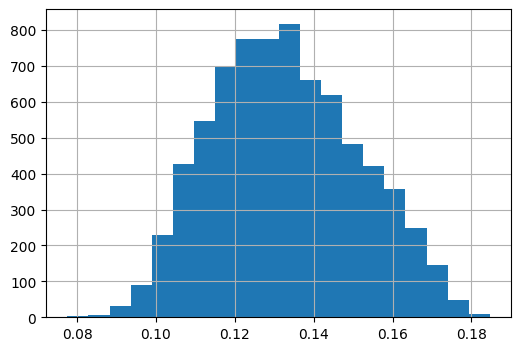

In [6]:
lt_score_embedd['longtail_scores'].hist(bins=20, figsize=[6,4])